# 29 ResNet

解决增加模型深度时，模型范围会偏离浅层模型的问题（没太看懂，先这么记录）

也可以解决梯度消失、梯度爆炸的问题

![](./assets/resnet_1.jpg)

## 残差层

残差层加入快速通道来得到$f(x)=g(x)+x$的结构

![](./assets/resnet_2.jpg)

当输入和输出维度相同时，可以直接向网络输出里加一个输入X；当输入和输出通道数或图像尺寸不同时，需要通过1x1卷积来调整维度。

（按我的理解，似乎只有当stride不为1或输入和输出通道数不同时，才需要1x1卷积来调整维度）

以下实现了一个残差层：

In [65]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

以下展示了几个残差块示例：

In [66]:
blk = Residual(3,3)
X = torch.rand(4,3,8,8)
Y = blk(X)
print(Y.shape)

torch.Size([4, 3, 8, 8])


In [67]:
blk = Residual(3,3,use_1x1conv=True,strides=2) # 当strides不为1或输入通道数不等于输出通道数时，都需要use_1x1conv=True
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 3, 3])

In [68]:
blk = Residual(32, 64, use_1x1conv=True, strides=2) # 当strides不为1或输入通道数不等于输出通道数时，都需要use_1x1conv=True
X = torch.rand(4, 32, 8, 8)
Y = blk(X)
print(Y.shape)

torch.Size([4, 64, 4, 4])


## ResNet模型

### ResNet前两层

ResNet的前两层跟之前介绍的GoogLeNet中的一样： 在输出通道数为64、步幅为2的$7×7$卷积层后，接步幅为2的$3×3$的最大汇聚层。 不同之处在于ResNet每个卷积层后增加了批量规范化层。

In [69]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

### ResNet主体单元

GoogLeNet在后面接了4个由Inception块组成的模块。 ResNet则使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。 第一个模块的通道数同输入通道数一致。 由于之前已经使用了步幅为2的最大汇聚层，所以无须减小高和宽。 之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

In [70]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [71]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

### ResNet最后——最大池化层、全连接层

加入nn.AdaptiveAvgPool2d((1,1))，这意味着每个输出通道尺寸为1*1

In [72]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

看一下每一层的输出形状：

In [73]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


## 训练模型

loss 0.012, train acc 0.997, test acc 0.918
2617.4 examples/sec on cuda:0


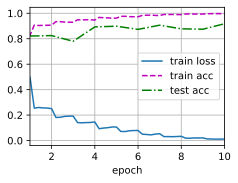

In [74]:
from d2l import torch as d2l

lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())